# Dépenses de consommation trimestrielles des ménages

## Data Management

### Importations des packages

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
#from mlxtend.plotting import plot_pca_correlation_graph
import os
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from pyfile import *
cwd = os.getcwd()

La première étape consiste à tout stationnariser

In [2]:
''' Mise au format datetime des index '''

import datetime as dt
lesdates = []
dernierJour = {
    1:31,
    2:28,
    3:31,
    4:30,
    5:31,
    6:30,
    7:31,
    8:31,
    9:30,
    10:31,
    11:30,
    12:31
}
for i in range(len(yty_var_tot)*3):
    annee = 2011+((i+4)//12)
    mois = (i+4)%12
    if mois == 0:
        mois += 12
        annee -= 1
    jour = dernierJour[mois]
    if (annee - 2008)%4 == 0 and mois == 2:
        jour = 29
    lesdates.append(dt.date(annee,mois,jour))
lesdates = pd.Index(lesdates)


In [3]:
''' Stationnarisation de yty_var '''

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
regX = pd.DataFrame()
regX['Constante'] = pd.Series(np.ones(len(yty_var_tot)))
regX['Temps'] = pd.Series(np.arange(1,len(yty_var_tot)+1))
regX.index = yty_var_tot.index

sm.OLS(yty_var_tot.iloc[:,0],regX).fit().pvalues # Tendance ct

Constante    0.000007
Temps        0.000008
dtype: float64

La régression sur la constante et le temps témoignent de coefficients significatifs. Il faut donc les ajouter à la régression du test ADF.

In [4]:
adfuller(yty_var_tot.iloc[:,0],regression = 'ct', maxlag=8, autolag='t-stat')[1] 

0.41837583922196697

On ne peut pas rejeter l'hypothèse de racine unité aux seuils habituels. Nous supposons donc que la série n'est pas stationnaire et que par conséquent il est nécessaire de la différencier une fois.

In [5]:
yty_var_tot = pd.DataFrame({'Variations de la consommation':var, 'Date':list(conso.index)[4:]})
yty_var_tot = yty_var_tot.set_index('Date').loc['2011T1':]
yty_var_tot = yty_var_tot.diff().iloc[1:,:]
yty_var_tot.index = lesdates[np.arange(2,len(lesdates),3)]
regX = pd.DataFrame()
regX['Constante'] = pd.Series(np.ones(len(yty_var_tot)))
regX['Temps'] = pd.Series(np.arange(1,len(yty_var_tot)+1))
regX.index = yty_var_tot.index
sm.OLS(yty_var_tot.iloc[:,0],regX).fit().pvalues # On appliquera le paramètre nc

adfuller(yty_var_tot.iloc[:,0],regression = 'nc', maxlag=8, autolag='t-stat')[1] # C'est bien stationnaire

3.5520983189440084e-06

Cette fois, nous pouvons rejeter à tous les niveaux habituels l'hypothèse de racine unité. Il est suffisant de ne différentier qu'une fois.

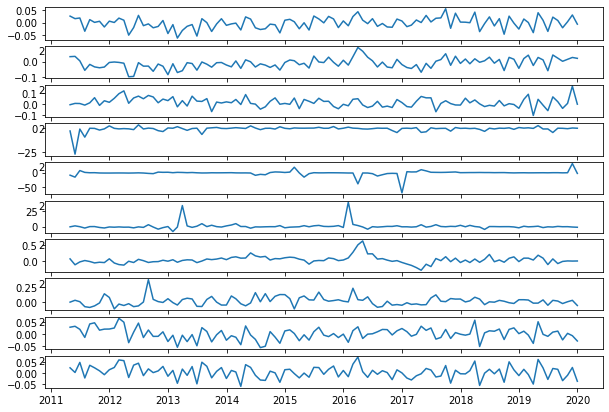

In [6]:
X_selectb = (X[selectionBrut].iloc[:117,:][::-1].diff(periods=12)/X[selectionBrut].iloc[:117,:][::-1].shift(periods=12)).iloc[12:,:] # On calcule en yty_var
X_selectb.index = lesdates

Nous transformons les variables explicatives au format yty_var pour être cohérent avec la variable cible. Aussi, cela permet une éventuelle neutralisation des effets saisonniers.

In [7]:
''' Stationnarisation de X '''

import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller 

regX = pd.DataFrame()
regX['Constante'] = pd.Series(np.ones(len(X_selectb)))
regX['Temps'] = pd.Series(np.arange(1,len(X_selectb)+1))
regX.index = X_selectb.index
ts = []
for i in range(len(X_selectb.columns)):
    ts.append((sm.OLS(X_selectb.iloc[:,i],regX).fit().pvalues < 0.05)) # On regarde pour chaque variable s'il y a une tendance déterministe


adftest = [] # On fait un test ADF pour chacune

for i in range(len(X_selectb.columns)):
    regressionmode = ''
    if ts[i][0] :
        regressionmode += 'c'
        if ts[i][1] :
            regressionmode += 't'
    else:
        regressionmode = 'nc'
    adftest.append(adfuller(X_selectb.iloc[:,i],regression = regressionmode, maxlag=24, autolag='t-stat')[1] < 0.05)

adftest # Il faut en différentier quelques-unes

[False, True, False, True, True, True, False, True, True, False]

Toutes les variables ne sont pas stationnaires. Nous allons toutes les différencier, par souci de cohérence de l'analyse.

In [8]:
X_selectb = (X[selectionBrut].iloc[:118,:][::-1].diff(periods=12)/X[selectionBrut].iloc[:118,:][::-1].shift(periods=12)).diff(periods=1).iloc[13:,:] # On prend une période de plus
X_selectb.index = lesdates

In [9]:
# On recommence les tests
regX = pd.DataFrame()
regX['Constante'] = pd.Series(np.ones(len(X_selectb)))
regX['Temps'] = pd.Series(np.arange(1,len(X_selectb)+1))
regX.index = X_selectb.index
ts = []
for i in range(len(X_selectb.columns)):
    ts.append((sm.OLS(X_selectb.iloc[:,i],regX).fit().pvalues < 0.05))

adftest = []

for i in range(len(X_selectb.columns)):
    regressionmode = ''
    if ts[i][0] :
        regressionmode += 'c'
        if ts[i][1] :
            regressionmode += 't'
    else:
        regressionmode = 'nc'
    adftest.append(adfuller(X_selectb.iloc[:,i],regression = regressionmode, maxlag=24, autolag='t-stat')[1] < 0.05)

adftest # Tout est stationnaire

[True, True, True, True, True, True, True, True, True, True]

Une seule différenciation est nécessaire.